<a href="https://colab.research.google.com/github/anarakinson/Segmentation-Construction_works-/blob/main/segmentation_Involution_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os, glob
import cv2

In [2]:
from google.colab import drive #a
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [21]:
# Путь к датасету
target_size = [512, 512]
shuffle_buffer = 32
batch_size = 4

data_dir = '/content/drive/MyDrive/Colab_Files/Datasets/stroyka/'
train_dir = data_dir + 'Тренировочная_стройка/'
test_dir = data_dir + 'Проверочная_стройка/'

images_dir = 'images'
masks_dir = 'masks_scaled'

In [22]:
# Имена и номера классов
class_names = {
    'пол' : 0,
    'потолок' : 1,
    'стена' : 2,
    'колонна' : 3,
    'проем' : 4,
    'дверь' : 5,
    'окно' : 6,
    'внешний мир' : 7,
    'лестница' : 8,
    'перила' : 9,
    'батарея' : 10,
    'люди' : 11,
    'инвентарь' : 12,
    'источники света' : 13,
    'провода' : 14,
    'балка' : 15,
    'остальное' : 16,
}

# Количество классов
num_classes = len(class_names)
print(num_classes)

17


In [23]:
# Цветовая карта для преобразования ответа нейросети в цветную маску
colormap = {
    0 : [100, 100, 100], # пол
    1 : [0, 0, 100], # потолок
    2 : [0, 100, 0], # стена
    3 : [100, 0, 0], # колонна
    4 : [0, 100, 100], # проем
    5 : [100, 0, 100], # дверь
    6 : [100, 100, 0], # окно
    7 : [200, 200, 200], # внешний мир
    8 : [0, 0, 200],  # лестница
    9 : [0, 200, 0],  # перила
    10 : [200, 0, 0],  # батарея
    11 : [0, 200, 200], # люди
    12 : [200, 0, 200], # инвентарь
    13 : [200, 200, 0], # источники света
    14 : [0, 100, 200], # провода
    15 : [100, 0, 200], # балка
    16 : [0, 0, 0] # остальное
}

In [24]:
def read_image(image_path, mask=False):
    '''
    Функция для загрузки изображения. 
    Получает путь, возвращает изображение
    Флаг "маска" определяет, фото или маска должна быть на выходе
    '''
    file = tf.io.read_file(image_path)
    if mask == False:
        image = tf.image.decode_jpeg(file, channels=3)
        image = tf.cast(image, tf.float32) / 127.5 - 1
    if mask:
        image = tf.image.decode_png(file, channels=1)
        # image = tf.squeeze(image)
    image = tf.image.resize(images=image, 
                            size=target_size)
    return image


def load_data(image_list, mask_list):
    '''
    Загрузка пар "фото-маска"
    '''
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    image, mask = random_jitter(image, mask)
    return image, mask

def get_dataset(image_list, mask_list):
    '''
    Загрузка датасета
    '''
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size)
    return dataset

In [25]:
@tf.function()
def random_jitter(input_image, output_image):
    '''
    Случайное дрожание и отражение изображения для аугментации
    '''
  # Увеличение изображения
    input_image, output_image = resize(input_image, output_image, 
                                    (target_size[0] + target_size[0]//10), 
                                    (target_size[1] + target_size[1]//10))

  # Случайная обрезка
    input_image, output_image = random_crop(input_image, output_image, target_size[0], target_size[1])

    if tf.random.uniform(()) > 0.5:
    # Случайное отражение по горизонтали
        input_image = tf.image.flip_left_right(input_image)
        output_image = tf.image.flip_left_right(output_image)

    # if tf.random.uniform(()) > 0.9:
    # # Случайное отражение по вертикали
    #     input_image = tf.image.flip_up_down(input_image)
    #     output_image = tf.image.flip_up_down(output_image)

    if tf.random.uniform(()) > 0.1:
    # Зашумление картинки
        input_image = tf.cast(input_image, tf.float32) * tf.random.uniform((input_image.shape), tf.random.uniform((), .3, .8), 0.99)

    return input_image, output_image

def resize(input_image, output_image, height, width):
    '''
    Увеличение изображения
    '''
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    output_image = tf.image.resize(output_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, output_image

def random_crop(input_image, output_image, height, width):
    '''
    Случайная обрезка и случайное вращение изображения
    '''
    # Стак обоих изображений для синхронной обрезки и поворота
    stacked_image = tf.concat([input_image, output_image], axis=-1)
    # Вращение
    rotated_image = rotation(stacked_image)
    # Обрезка
    cropped_image = tf.image.random_crop(
        rotated_image, size=[height, width, 4])

    return cropped_image[..., :-1], tf.expand_dims(cropped_image[..., -1], -1)

In [26]:
# Загрузка датасета
train_images = sorted(glob.glob(os.path.join(train_dir, images_dir, '*')))
train_masks = sorted(glob.glob(os.path.join(train_dir, masks_dir, '*')))
test_images = sorted(glob.glob(os.path.join(test_dir, images_dir, '*')))
test_masks = sorted(glob.glob(os.path.join(test_dir, masks_dir, '*')))

# Слой для случайного вращения изображений на выходе датасета
rotation = layers.experimental.preprocessing.RandomRotation(factor=0.07)

# Создание датасета
train_dataset = get_dataset(train_images, train_masks)
test_dataset = get_dataset(test_images, test_masks)

print("Train Dataset lenght:", len(train_dataset))
print("Val Dataset lenght:", len(test_dataset))
print("\nTrain Dataset:", (train_dataset))
print("Val Dataset:", (test_dataset))

Train Dataset lenght: 225
Val Dataset lenght: 13

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>


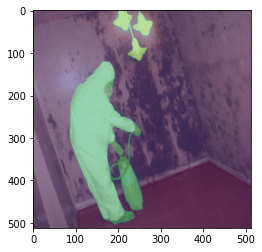

In [27]:
# Пример изображения из датасета с наложенной маской.
for img, mask in test_dataset:
    plt.imshow((img[0].numpy()*127.5+127.5).astype('int'))
    plt.imshow((np.squeeze(mask[0])), alpha=0.5)
    plt.show()
    break

# Neural Network

Стать по теме Involution - https://habr.com/ru/post/578308/

In [28]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Инициализация параметров.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Получаем размерности входного тензора.
        (_, height, width, num_channels) = input_shape

        # Масштабируем высоту и ширину в соответствии с шагам сверточного ядра.
        height = height // self.stride
        width = width // self.stride

        # Задаем слой для усредненного пулинга тензора.
        # Только в случае, если шаг более 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Задаем блок сверток с активацией и нормализацией.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Задаем слои решейпа.
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Создаем сверточный блок.
        # Batch, Height, Width, Kernel_size*Kernel_size*Group_number
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # решейпим тензор
        # Batch, Height, Width, Kernel_size*Kernel_size, 1, Group_number
        kernel = self.kernel_reshape(kernel)

        # Извлекаем входной тензор, поделенный на патчи (patches).
        # Batch, Height, Width, Kernel_size*Kernel_size*Channels
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Решейпим входной тензор, поделенный на патчи для возможности дальнейшей обработки.
        # Batch, Height, Width, Kernel_size*Kernel_size, Channels//Group_number, Group_number
        input_patches = self.input_patches_reshape(input_patches)

        # Вычисляем произведение и сумму сверточного блока и патчей входного тензора.
        # Batch, Height, Width, K*K, Channels//Group_number, Group_number
        output = tf.multiply(kernel, input_patches)
        # Batch, Height, Width, Channels//Group_number, Group_number
        output = tf.reduce_sum(output, axis=3)

        # Решейпим выходной тензор.
        # Batch, Height, Width, Channels
        output = self.output_reshape(output)

        # Возвращаем выходной тензор
        return output

In [51]:
def convolution_block(
    x,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding='same',
    use_bias=True,
    kernel_regularizer=None
):
    '''
    Функция создает сверточный блок с нормализацией и активацией
    '''
    x = layers.Conv2D(filters=num_filters,
                     kernel_size=kernel_size,
                     dilation_rate=dilation_rate,
                     padding=padding,
                     use_bias=use_bias,
                     kernel_initializer=tf.keras.initializers.HeNormal())(x)
    x = layers.BatchNormalization()(x)
    return tf.nn.leaky_relu(x)

def pyramid_pooling(inputs): # Dilated Spatial Pyramid Pooling

    dims = inputs.shape
    # Сжимаем входной тензор до размера 1х1, обрабатываем и возвращаем в исходный размер
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(inputs)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1],
              dims[-2] // x.shape[2]),
        interpolation='bilinear'
    )(x)

    # Добавляем инволюционный блок
    out0 = Involution(
        channel=4, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
    )(inputs)
    
    # Добавляем сверточные блоки с различным размером разреженности (dilation_rate)
    out1 = convolution_block(inputs, kernel_size=1, dilation_rate=1)
    out6 = convolution_block(inputs, kernel_size=3, dilation_rate=6)
    out12 = convolution_block(inputs, kernel_size=3, dilation_rate=12)
    out18 = convolution_block(inputs, kernel_size=3, dilation_rate=18)
    
    x = layers.concatenate([out_pool, out1, out6, out12, out18, out0])
    
    return convolution_block(x, kernel_size=1)

In [52]:
def get_model(num_classes):
    '''
    Функция создает нейросеть на базе ResNet50 
    '''

    regularizer = tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001)

    inputs = layers.Input((*target_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_tensor=inputs
    )
    x = resnet50.get_layer('conv4_block6_2_relu').output
    x = pyramid_pooling(x)

    input_a = layers.UpSampling2D(size=(target_size[0] // 4 // x.shape[1],
                                        target_size[1] // 4 // x.shape[2]),
                                    interpolation='bilinear')(x)

    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b_out = convolution_block(input_b, num_filters=64, kernel_size=1, kernel_regularizer=regularizer)
    input_b = convolution_block(input_b_out, num_filters=64, kernel_size=3, kernel_regularizer=regularizer)

    input_b2 = Involution(
        channel=4, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="input_b2"
    )(input_b_out)
    input_b = layers.concatenate([input_b, input_b2])
    input_b = convolution_block(input_b, num_filters=64, kernel_size=1, kernel_regularizer=regularizer)

    input_c = resnet50.get_layer("conv3_block4_2_relu").output
    input_c_out = convolution_block(input_c, num_filters=64, kernel_size=1, kernel_regularizer=regularizer)
    input_c = convolution_block(input_c_out, num_filters=128, kernel_size=3, kernel_regularizer=regularizer)
    input_c = layers.UpSampling2D()(input_c)
    input_c = convolution_block(input_c, num_filters=64, kernel_size=3, kernel_regularizer=regularizer)
    input_c = convolution_block(input_c, num_filters=64, kernel_size=1, kernel_regularizer=regularizer)

    input_d = resnet50.get_layer("conv5_block3_2_relu").output
    input_d_out = convolution_block(input_d, num_filters=64, kernel_size=1, kernel_regularizer=regularizer)
    input_d = convolution_block(input_d, num_filters=256, kernel_size=3, kernel_regularizer=regularizer)
    input_d = layers.UpSampling2D()(input_d)
    input_d = layers.concatenate([input_d, x])
    input_d = convolution_block(input_d, num_filters=128, kernel_size=3, kernel_regularizer=regularizer)
    input_d = convolution_block(input_d, num_filters=128, kernel_size=1, kernel_regularizer=regularizer)
    input_d = layers.UpSampling2D()(input_d)
    input_d = layers.concatenate([input_d, input_c_out])
    input_d = convolution_block(input_d, num_filters=64, kernel_size=3, kernel_regularizer=regularizer)
    input_d = convolution_block(input_d, num_filters=64, kernel_size=1, kernel_regularizer=regularizer)
    input_d = layers.UpSampling2D()(input_d)
    input_d = layers.concatenate([input_d, input_b_out])
    input_d = convolution_block(input_d, num_filters=64, kernel_size=3, kernel_regularizer=regularizer)
    input_d = convolution_block(input_d, num_filters=64, kernel_size=1, kernel_regularizer=regularizer)

    input_c_out = layers.UpSampling2D()(input_c_out)
    input_d_out = layers.UpSampling2D(8)(input_d_out)
    res_inputs = layers.concatenate([input_b_out, input_c_out, input_d_out])

    x = layers.concatenate([input_a, input_b, input_c, input_d])
    x = convolution_block(x, use_bias=True, kernel_regularizer=regularizer)
    x = layers.concatenate([x, res_inputs])
    x = convolution_block(x, use_bias=True, kernel_regularizer=regularizer)
    x = layers.UpSampling2D(size=(target_size[0] // x.shape[1],
                                    target_size[1] // x.shape[2]),
                            interpolation='bilinear')(x)

    outputs = layers.Conv2D(num_classes, kernel_size=1, padding='same')(x)
    
    return tf.keras.Model(inputs, outputs)

In [53]:
class GCAdam(tf.keras.optimizers.Adam):
    def get_gradients(self, loss, params):
        '''
        Оптимизатор для централизации градиента, ускоряющий процесс обучения
        '''
        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads
    
class MeanIoU(tf.keras.metrics.MeanIoU):
    '''
    Метрика Intersection-over-Union для измерения, насколько совпадают две маски
    '''
    def __init__(self,
                 y_true=None,
                 y_pred=None,
                 num_classes=None,
                 name='IoU',
                 dtype=None):
        super(MeanIoU, self).__init__(num_classes = num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

class Schedule():
    '''
    Расписание уменьшения шага обучения для коллбэка
    Уменьшение начинается co start_epoch и происходит каждые per_epoch
    '''
    def __init__(self, start_epoch=5, per_epoch=1):
        self.start_epoch = start_epoch
        self.per_epoch = per_epoch

    def __call__(self, epoch, lr):
        if epoch >= self.start_epoch and epoch % self.per_epoch == 0:
            lr *= tf.math.exp(-0.1)
        print('learning rate:', float(lr))
        return lr

def dice_coef_cat(y_true, y_pred, smooth=1e-7):
    '''
    Коэффициент Соренсена-Дайса для категориальной сегментации.
    Используется как метрика при обучении модели.
    '''
    y_true_f = tf.keras.backend.flatten(tf.one_hot(tf.cast(y_true, tf.int32), num_classes))
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersect = tf.reduce_sum(y_true_f * y_pred_f, axis=-1)
    denom = tf.reduce_sum(y_true_f + y_pred_f, axis=-1)
    return tf.abs(tf.reduce_mean((2. * intersect / (denom + smooth))))

def dice_coef_cat_loss(y_true, y_pred):
    '''
    Коэффициент Соренсена-Дайса для категориальной сегментации.
    Используется как минимизируемая функция ошибки при обучении модели.
    '''
    return 1 - dice_coef_cat(y_true, y_pred)

def combined_loss(y_true, y_pred):
    '''
    Комбинированная функция ошибки, состоящая из кроссэнтропии и ошибки Дайса
    '''
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred) + (1 - dice_coef_cat(y_true, y_pred))

In [54]:
model = get_model(num_classes)

In [55]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/segmentation/segmentation_model-involutionv2.h5')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# сборка модели
schedule_callback = tf.keras.callbacks.LearningRateScheduler(Schedule(10, 1))
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = GCAdam(1e-05)
metrics = [MeanIoU(num_classes=num_classes),
           tf.keras.metrics.sparse_categorical_accuracy]
callbacks = [schedule_callback]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Обучение
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=15,
                    initial_epoch=0,
                    callbacks=callbacks
                    )

learning rate: 9.999999747378752e-05
Epoch 1/15
225/225 [==============================] - 315s 1s/step - loss: 1.1658 - IoU: 0.1519 - sparse_categorical_accuracy: 0.6883 - val_loss: 3.9304 - val_IoU: 0.0241 - val_sparse_categorical_accuracy: 0.4022 - lr: 1.0000e-04
learning rate: 9.999999747378752e-05
Epoch 2/15
225/225 [==============================] - 284s 1s/step - loss: 0.7958 - IoU: 0.2211 - sparse_categorical_accuracy: 0.7669 - val_loss: 4.3611 - val_IoU: 0.0245 - val_sparse_categorical_accuracy: 0.4067 - lr: 1.0000e-04
learning rate: 9.999999747378752e-05
Epoch 3/15
225/225 [==============================] - 288s 1s/step - loss: 0.6859 - IoU: 0.2612 - sparse_categorical_accuracy: 0.7970 - val_loss: 4.3943 - val_IoU: 0.0351 - val_sparse_categorical_accuracy: 0.3617 - lr: 1.0000e-04
learning rate: 9.999999747378752e-05
Epoch 4/15
225/225 [==============================] - 286s 1s/step - loss: 0.6398 - IoU: 0.2818 - sparse_categorical_accuracy: 0.8054 - val_loss: 1.2911 - val_IoU

In [ ]:
# Обучение
history2 = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    initial_epoch=15,
    callbacks=callbacks,
    verbose=0    
)

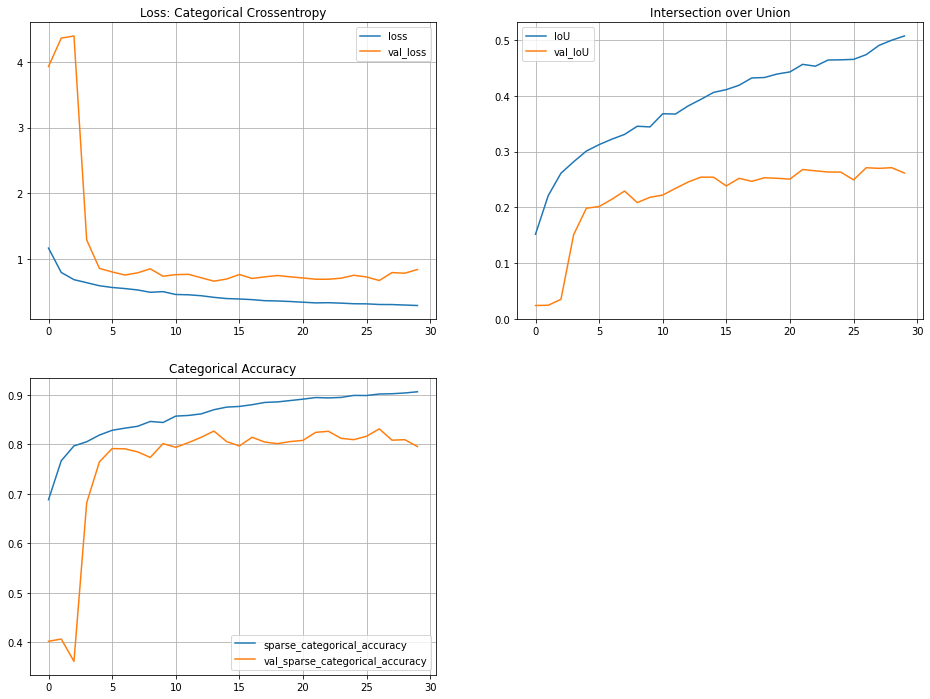

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.title('Loss: Categorical Crossentropy')
plt.plot(history.history['loss'] + history2.history['loss'], label='loss')
plt.plot(history.history['val_loss'] + history2.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.subplot(2, 2, 2)
plt.title('Intersection over Union')
plt.plot(history.history['IoU'] + history2.history['IoU'], label='IoU')
plt.plot(history.history['val_IoU'] + history2.history['val_IoU'], label='val_IoU')
plt.legend()
plt.grid()
plt.subplot(2, 2, 3)
plt.title('Categorical Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'] + history2.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'] + history2.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/segmentation_CCT/segmentation_model-involution.h5')

# Test

In [ ]:
model.evaluate(test_dataset)

13/13 [==============================] - 8s 416ms/step - loss: 0.7265 - IoU: 0.2796 - sparse_categorical_accuracy: 0.8120


[0.7264843583106995, 0.27959945797920227, 0.8120496273040771]

In [40]:
def infer(image_tensor, model):
    '''
    Функция возвращает предсказание модели
    '''
    predictions = model.predict(np.expand_dims(image_tensor, axis=0))
    return np.argmax(predictions[0], axis=2)

def decode_mask(mask, colormap, n_classes):
    '''
    Функция получает предсказание модели и возвращает раскрашенную маску сегментации
    '''
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    
    for l in range(n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
        
    return np.stack([r, g, b], axis=2)

def get_overlay(image, mask):
    '''
    Функция накладывает маску на изображение
    '''
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    return cv2.addWeighted(image, 0.35, mask, 0.65, 0) # image * 0.35 + mask * 0.65 + 0

def plot_samples(images):
    '''
    Функция для отрисовки изображений
    '''
    plt.figure(figsize=(20, 4))
    for i in range(len(images)):
        plt.subplot(1, 2+len(images), 1+i)
        if images[i].shape[-1] == 3:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]),
                      vmin=0, vmax=255)
        else:
            plt.imshow(images[i])
        plt.axis('off')
    plt.subplot(1, 2+len(images), 2+i)
    plt.imshow((np.array(list(colormap.values()))).reshape(17, 1, 3))
    plt.xticks([])
    plt.yticks(ticks=list(class_names.values()),
               labels = list(class_names.keys()))
    plt.tight_layout()
    plt.show()
    
def plot_predictions(images, colormap, model):
    '''
    Функция получает адреса изображений и передает их в модель для сегментации
    '''
    for image in images:
        image_tensor = read_image(image)
        prediction = infer(image_tensor, model)
        decoded_mask = decode_mask(prediction, colormap, num_classes)
        decoded_mask[0, 0, 0] = 255
        decoded_mask[0, 0, 1] = 0
        overlay = get_overlay(image_tensor, decoded_mask)
        plot_samples([image_tensor, overlay, decoded_mask])

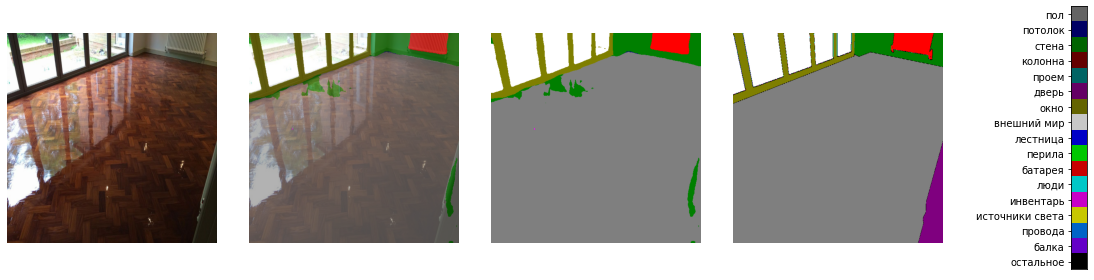

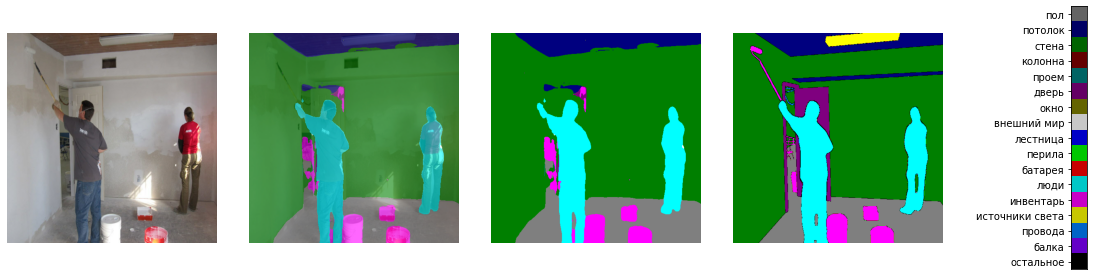

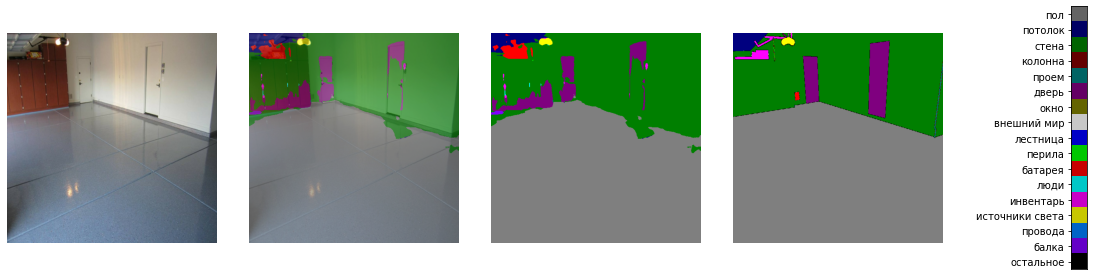

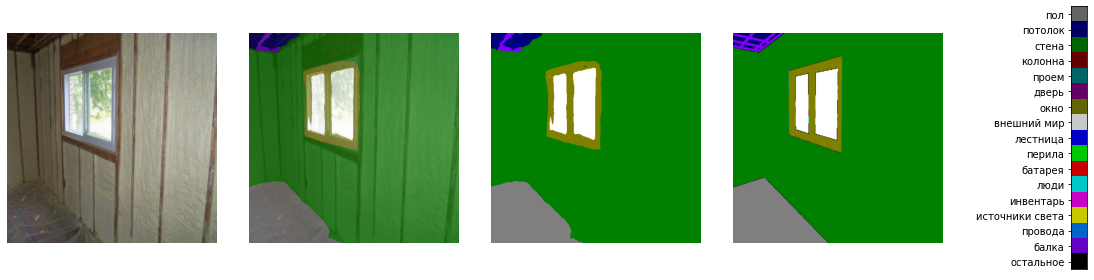

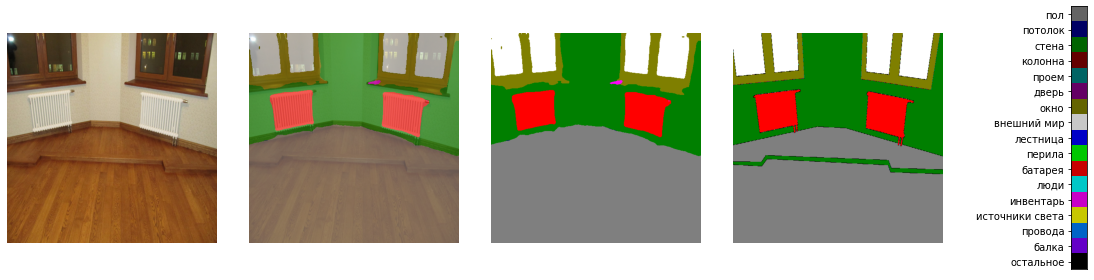

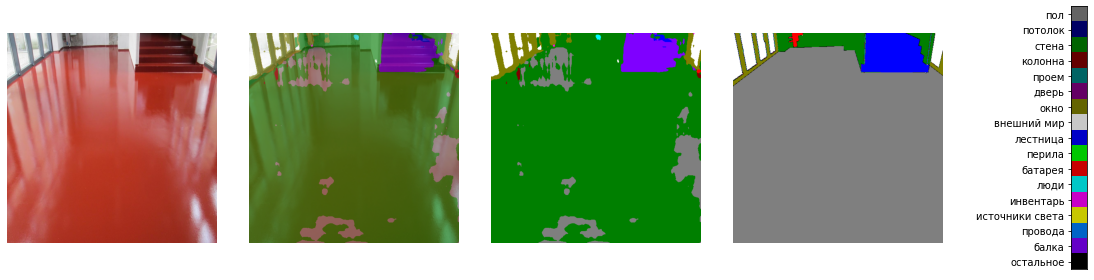

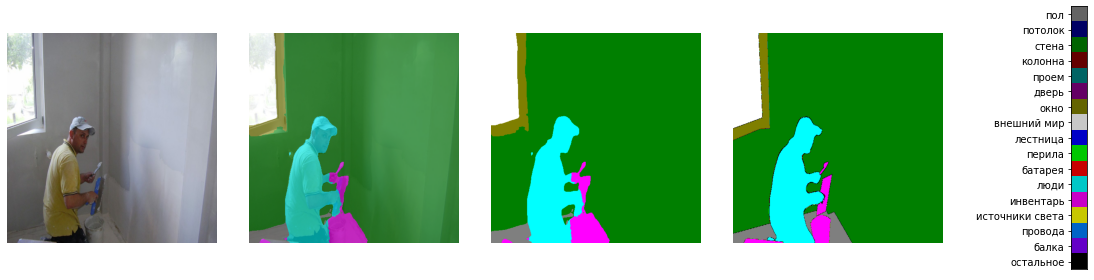

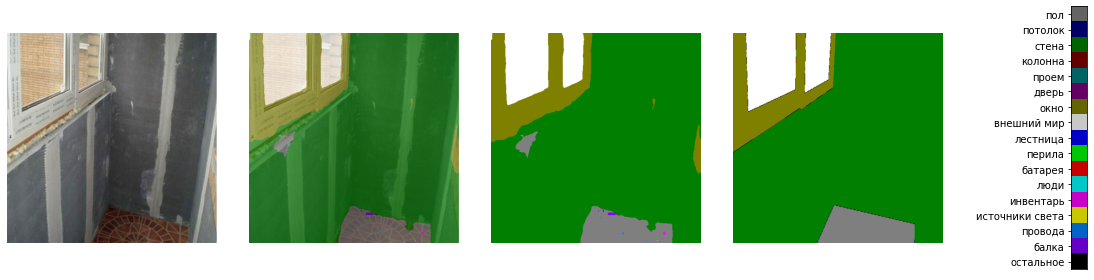

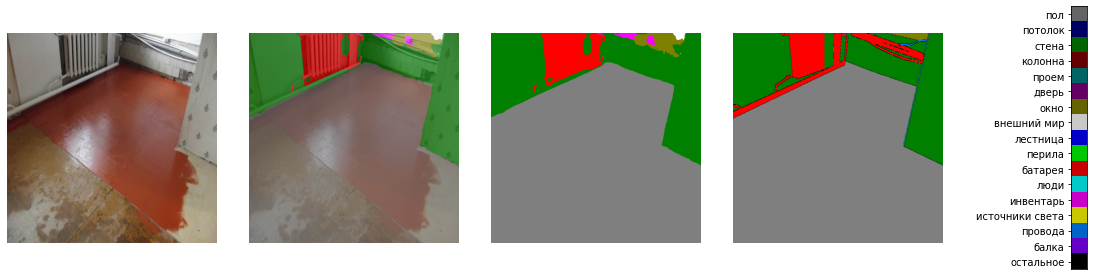

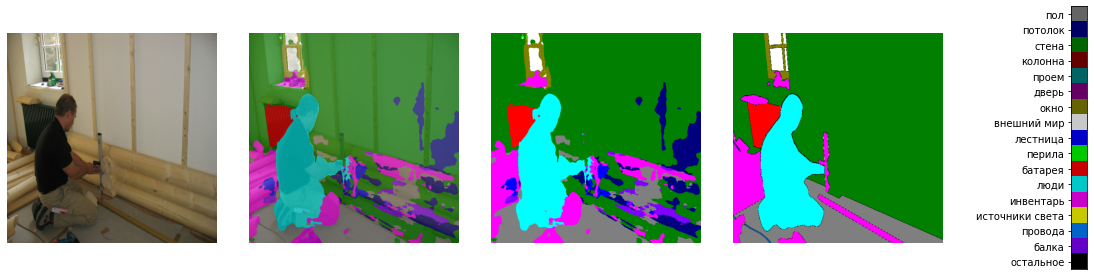

In [56]:
# пример сегнентации с помощью модели
# крайнее справа изображение - эталон, размеченный человеком
colormap2 = np.array(list(colormap.values()))
n = np.random.choice(np.arange(len(test_images)), 10, replace=False)

images = [test_images[i] for i in n]
masks = [test_masks[i] for i in n]
for image, mask in zip(images, masks):
    image_tensor = read_image(image)
    mask_tensor = read_image(mask, mask=True)
    prediction = infer(image_tensor, model)
    decoded_mask = decode_mask(prediction, colormap2, num_classes)
    orig_mask = decode_mask(mask_tensor, colormap2, num_classes)
    overlay = get_overlay(image_tensor, decoded_mask)
    plot_samples([image_tensor, overlay, decoded_mask, np.squeeze(orig_mask)])